# NLP - Real or not Disaster tweets
## GOAL

Predict which tweets are about real disasters and which ones are not.

In this notebook two models are available. The second one is more efficient, you can add yours in choose_model function and change the model_number in User Interface

## User interface

In [40]:
# Choose parameters for this application

# There are 2 models available, number 1 or number 2
model_number = 2

# Size is the ratio between data train size and data test size in percent
# e.g. size = 80
size = 80

# Choose learning rate schedule parameters for Adam optimizer
initial_learning_rate = 0.0001
decay_steps = 1000
decay_rate = 0.95

# Parameter threshold for sigmoid activation function
thresholds = 0.5

# Choose epochs number for model training
epochs = 10


## Import libraries

In [6]:
# Import libraries
import tensorflow as tf

#tf.enable_eager_execution()

import tensorflow_datasets as tfds


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import en_core_web_sm
from spacy.lang.fr.stop_words import STOP_WORDS

import re

nlp = en_core_web_sm.load()

## Define functions

In [7]:
# Create Tensorflow dataset from pandas dataframe
def create_tf_dataset(dataset):
    tf_ds = tf.data.Dataset.from_tensor_slices((dataset.iloc[:,0].values, dataset.iloc[:,1].values))
    
    return tf_ds

In [8]:
# Create doc of tokens
def create_token_doc(data):
    
    corpus = ' '.join(data)
    corpus = corpus.strip().encode("utf-8").decode("utf-8")
    
    # Lower the text
    corpus = corpus.lower()
    
    corpus = re.sub(r"http\S+", "", corpus)
    corpus = re.sub(r"@\S+", "", corpus)
    corpus = re.sub(r"\x89\S+", "", corpus) 
    #corpus = re.sub(r"\n\S+", "", corpus)
    
    # Delete double blanks
    corpus = re.sub(r"\s+", " ", corpus)
    
    corpus = tf.keras.preprocessing.text.text_to_word_sequence(corpus,
                                                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n0123456789',
                                                      lower=True,
                                                      split=' ')
    
    corpus = ' '.join(corpus)
    
    # Check size because nlp.max_length is blocked at 1000000
    if len(corpus) >= 1000000:
        nlp.max_length = len(corpus)+1 # +1 for safety
        doc = nlp(corpus)
    else:
        doc = nlp(corpus)
    
    return doc

In [9]:
# Clean doc of tokens
def tokens_cleaning(doc):
    
    # Create list of word tokens
    token_list = []
    for token in doc:
        token_list.append(token.text)
    
    # Create list of word tokens after removing stopwords
    stop_word_removed = [] 

    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            stop_word_removed.append(word) 
    
    # Create list of word token after removing punctuation
    punctuation_removed = [] 

    for word in stop_word_removed:
        lexeme = nlp.vocab[word]
        if lexeme.is_punct == False:
            punctuation_removed.append(word)
            
    # Create list of word token after removing numbers
    digit_removed = []
    
    for word in punctuation_removed:
        lexeme = nlp.vocab[word]
        if lexeme.is_digit == False:
            digit_removed.append(word) 
        
    doc = nlp(' '.join(digit_removed))
    
    # Lemmatization
    doc_cleaned = [token.lemma_ for token in doc]
    
    return doc_cleaned

In [10]:
# Create set for vocabulary
def set_lemma_list(lemma_list):
    vocabulary_set= set(lemma_list)
    
    return vocabulary_set

In [11]:
# Encode all dataset elements 
def encode(text_tensor, label):
  encoded_text = encoder.encode(text_tensor.numpy())

  return encoded_text, label

# Encode all dataset
def encode_map_fn(text, label):
    
  return tf.py_function(encode, inp=[text, label], Tout=(tf.int64, tf.int64))

In [12]:
# Define models
def choose_model(choice):
    if choice == 1:
        model = tf.keras.Sequential([
                  # Input Word Embedding laler          
                  tf.keras.layers.Embedding(encoder.vocab_size, 64),

                  # Bidirectional LSTM layer
                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),

                  # Couche CNN
                  tf.keras.layers.Conv1D(16, 3, activation="relu"),
                  
                  # LSTM Layer
                  tf.keras.layers.LSTM(32, return_sequences=False),               

                  # Classic Dense layers
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dense(32, activation='relu'),
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),

                  # Dense layer for output
                  tf.keras.layers.Dense(1, activation="sigmoid")
            ])
            
            
    if choice == 2:
            model = tf.keras.Sequential([
                # Input Word Embedding laler   
                tf.keras.layers.Embedding(encoder.vocab_size, 64),
                
                # Bidirectional LSTM layer
                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                
                # Classic Dense layers
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(16, activation='relu'),
                tf.keras.layers.Dense(8, activation='relu'),
                
                # Dense layer for output
                tf.keras.layers.Dense(1, activation='sigmoid')
            ])

            
            
    model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.binary_crossentropy,
                    metrics=METRICS)
    
    return model

## Import data

In [13]:
# Import data
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")
example_submission = pd.read_csv('sample_submission.csv')

## Data preprocessing for encoding with train & test data

In [14]:
data = pd.concat([data_train, data_test])

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


In [16]:
# Create doc with tokens
data = data.text
doc = create_token_doc(data)

# Clean doc 
doc_cleaned = tokens_cleaning(doc)

# Create vocabulary set
vocabulary_set = set_lemma_list(doc_cleaned)

# Encode each tokens with number
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [20]:
data_train = data_train.loc[:,['text', 'target']]

In [21]:
tf_ds_train = create_tf_dataset(data_train)

tf_ds_train = tf_ds_train.shuffle(len(data_train))

doc_train = create_token_doc(data_train.text)

doc_train_cleaned = tokens_cleaning(doc_train)

all_encoded_data_train = tf_ds_train.map(encode_map_fn)

In [26]:
# Train Test Split
TAKE_SIZE = int((size/100)*len(data_train))

train_data = all_encoded_data_train.take(TAKE_SIZE).shuffle(len(data_train))
train_data = train_data.padded_batch(16,  padded_shapes=([-1], []))

test_data = all_encoded_data_train.skip(TAKE_SIZE)
test_data = test_data.padded_batch(16, padded_shapes=([-1], []))

## Train and test data preprocessing

In [27]:
data_test['label'] = 1
data_test = data_test.loc[:,['text', 'label']]

tf_ds_test = create_tf_dataset(data_test)

tf_ds_test = tf_ds_test.shuffle(len(data_test))

doc_test = create_token_doc(data_test.text)

doc_test_cleaned = tokens_cleaning(doc_test)


In [28]:
all_encoded_data_test = tf_ds_test.map(encode_map_fn)

test_output = all_encoded_data_test
test_output = test_output.padded_batch(16, padded_shapes=([-1], []))


## Train model

In [41]:
# Create learning rate schedule to decrease learning rate with model training
initial_learning_rate = initial_learning_rate

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)

# Create Adam optimizer for gradient calculations
optimizer= tf.keras.optimizers.Adam(
    learning_rate=lr_schedule
)

# Define some interesting metrics
thresholds=thresholds

METRICS = [
      tf.keras.metrics.TruePositives(name='tp',thresholds=thresholds),
      tf.keras.metrics.FalsePositives(name='fp',thresholds=thresholds),
      tf.keras.metrics.TrueNegatives(name='tn',thresholds=thresholds),
      tf.keras.metrics.FalseNegatives(name='fn',thresholds=thresholds),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [43]:
# Train model
model = choose_model(model_number)

epochs = epochs
history = model.fit(train_data, epochs=epochs, validation_data=test_data)

Epoch 1/10
381/381 [==============================] - 11s 28ms/step - loss: 0.6787 - tp: 1.0000 - fp: 4.0000 - tn: 3465.0000 - fn: 2620.0000 - accuracy: 0.5691 - precision: 0.2000 - recall: 3.8153e-04 - auc: 0.5394 - val_loss: 0.6563 - val_tp: 9.0000 - val_fp: 6.0000 - val_tn: 877.0000 - val_fn: 631.0000 - val_accuracy: 0.5817 - val_precision: 0.6000 - val_recall: 0.0141 - val_auc: 0.6600
Epoch 2/10
381/381 [==============================] - 10s 25ms/step - loss: 0.6220 - tp: 1294.0000 - fp: 755.0000 - tn: 2728.0000 - fn: 1313.0000 - accuracy: 0.6604 - precision: 0.6315 - recall: 0.4964 - auc: 0.7082 - val_loss: 0.5662 - val_tp: 409.0000 - val_fp: 168.0000 - val_tn: 720.0000 - val_fn: 226.0000 - val_accuracy: 0.7413 - val_precision: 0.7088 - val_recall: 0.6441 - val_auc: 0.7746
Epoch 3/10
381/381 [==============================] - 9s 24ms/step - loss: 0.5582 - tp: 1791.0000 - fp: 817.0000 - tn: 2660.0000 - fn: 822.0000 - accuracy: 0.7309 - precision: 0.6867 - recall: 0.6854 - auc: 0.78

## Evaluate model

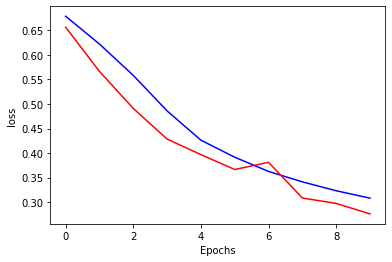

In [44]:
# Visualize the loss function
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

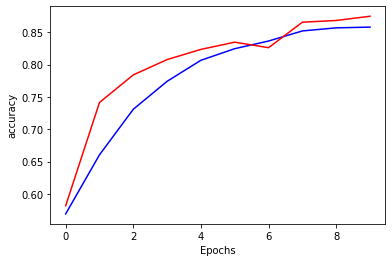

In [45]:
# Visualize training accuracy
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [46]:
liste_f1_score = []

for i in range(1, epochs):
  liste_f1_score.append(2*(history.history['val_precision'][i]*history.history['val_recall'][i])/(history.history['val_precision'][i]+history.history['val_recall'][i]))

f1_score = liste_f1_score[epochs-2]
print("F1_Score =", f1_score)

F1_Score = 0.8531898554068086


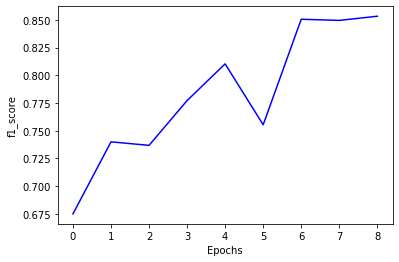

In [47]:
# Visualize F1 score 
plt.plot(liste_f1_score, color="b")
plt.ylabel("f1_score")
plt.xlabel("Epochs")
plt.show()

In [48]:
# Display Confusion Matrix
tn=int(history.history['val_tn'][epochs-1])
fp=int(history.history['val_fp'][epochs-1])
fn=int(history.history['val_fn'][epochs-1])
tp=int(history.history['val_tp'][epochs-1])

cm = np.array([[tn,fp],[fn,tp]])
cm

array([[777, 108],
       [ 83, 555]])

## Predictions

In [49]:
pred = model.predict(test_output)

In [50]:
pred = pred.reshape(3263)

In [51]:
for i in range(len(pred)):
    if pred[i] > 0.5:
        pred[i] = 1
    else:
        pred[i] = 0         

In [52]:
pred = pred.astype(int)

## Create csv file with predictions

In [53]:
if model_number == 1:
    output = 'tweeter_model_1.csv'
if model_number == 2:
    output = 'tweeter_model_2.csv'

target_predictions = pd.DataFrame(data=pred, columns=['target'])
target_predictions = pd.concat([example_submission.id, target_predictions.target], axis=1 )
target_predictions.to_csv(output, index=False)
